## 0. Abstract

- 대상 : 오프라인 매장을 운영하는 유통업체(B2C)
- 사용자 : 매장직원
- 목표 : 제품 사진 촬영 시, 해당 제품을 인식하고 정보를 불러옴
- 환경 : 제휴 논의 단계로 제공받은 데이터가 없는 상황에서 프로토타입 모델 제작이 필요

## 1. Import libraries

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import confusion_matrix, classification_report

import keras.optimizers as optimizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


import warnings
warnings.filterwarnings('ignore')

## 2. Collect data

<img src="files/image/image_recognition_1.png">

- 대상 업체로부터 제공받은 데이터가 없으므로 수작업으로 이미지셋을 제작, 브라우저 확장프로그램으로 해당 브랜드의 제품군별로 이미지를 저장

- 5개 제품군(Jacket, Skirt, T-shirt, Polo-shirt, Shoes) 총 1200개 이미지

- 폴더트리, 트레인/테스트 별 각 5개 폴더

## 3. Load data with data augmentation

#### - 데이터의 양이 매우 적은 상황이므로 data augmentation 활용

In [57]:
# Get train data and its augmented data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15, #randomly rotate images in 0~15 degrees
                                   width_shift_range=0.1, #randomly translate images
                                   height_shift_range=0.1, #randomly translate images
                                   shear_range=0.1, #applying shearing
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'd://image//train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical') #multi-class classification

# get test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'd://image//test',
        target_size=(150, 150),    
        batch_size=20,
        class_mode='categorical')

Found 873 images belonging to 5 classes.
Found 305 images belonging to 5 classes.


## 4. Define model

In [58]:
model = Sequential() # linear stacks of layers

### first layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))


### shrink dimensions of the previous layer to solve over-fitting problem
model.add(MaxPooling2D(pool_size=(2, 2)))

### second layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### third layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
       
### fourth layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### Convert it to 1-dimension tensor (ventor)
model.add(Flatten())
model.add(Dropout(0.5))
# fourth layer
model.add(Dense(512, activation='relu'))

# Output layer, it returns probabilities of samples being each class(there are 3 classes)
model.add(Dense(5, activation='softmax'))

In [59]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

In [60]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=test_generator,
                              validation_steps=50)

Epoch 1/50
100/100 [==============================] - 426s 4s/step - loss: 1.5676 - acc: 0.2399 - val_loss: 1.5708 - val_acc: 0.2911
Epoch 2/50
100/100 [==============================] - 416s 4s/step - loss: 1.5336 - acc: 0.3092 - val_loss: 1.5310 - val_acc: 0.3414
Epoch 3/50
100/100 [==============================] - 413s 4s/step - loss: 1.4721 - acc: 0.3532 - val_loss: 1.4703 - val_acc: 0.3560
Epoch 4/50
100/100 [==============================] - 420s 4s/step - loss: 1.4326 - acc: 0.3910 - val_loss: 1.4895 - val_acc: 0.3812
Epoch 5/50
100/100 [==============================] - 454s 5s/step - loss: 1.3781 - acc: 0.4104 - val_loss: 1.4110 - val_acc: 0.3780
Epoch 6/50
100/100 [==============================] - 467s 5s/step - loss: 1.3315 - acc: 0.4634 - val_loss: 1.4663 - val_acc: 0.3340
Epoch 7/50
100/100 [==============================] - 440s 4s/step - loss: 1.3001 - acc: 0.4613 - val_loss: 1.4347 - val_acc: 0.3581
Epoch 8/50
100/100 [==============================] - 457s 5s/step - 

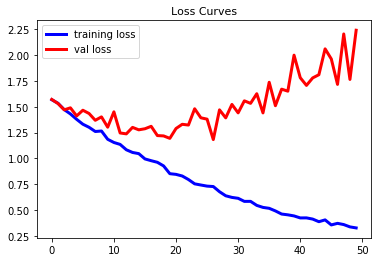

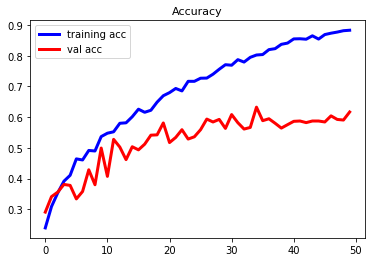

Training acc: 0.8827
val acc: 0.6168


In [62]:
#Plot the Loss Curves and accuracy

plt.plot(history.history['loss'],'b',linewidth=3.0, label='training loss')
plt.plot(history.history['val_loss'],'r',linewidth=3.0, label='val loss')
plt.title('Loss Curves',fontsize=11)
plt.legend()

plt.figure()
plt.plot(history.history['acc'],'b',linewidth=3.0, label='training acc')
plt.plot(history.history['val_acc'],'r',linewidth=3.0, label='val acc')
plt.title('Accuracy',fontsize=11)
plt.legend()
plt.show()

print("Training acc: {:.4f}".format(history.history['acc'][-1]))
print("val acc: {:.4f}".format(history.history['val_acc'][-1]))

In [63]:
model.save('five_class_classifier_1.h5')

## 5. Diagnose misclassification

컨퓨전 매트릭스 쓰기

In [108]:
y_pred_prob = model.predict_generator(test_generator, 16)
collections.Counter(np.argmax(y_pred_prob, axis=1))

Counter({2: 60, 0: 87, 3: 41, 1: 92, 4: 25})

In [109]:
y_pred = np.argmax(y_pred_prob, axis=1)
print(len(y_pred), len(test_generator.classes))

305 305


In [110]:
confusion_matrix(test_generator.classes, y_pred)

array([[24, 32, 18,  8,  8],
       [13, 13, 14, 10,  5],
       [25, 27, 16, 10,  8],
       [15, 11,  7,  9,  1],
       [10,  9,  5,  4,  3]], dtype=int64)

In [111]:
print(classification_report(test_generator.classes, y_pred, target_names=['jacket', 'polo','shoes', 'skirt', 'tshirt']))

              precision    recall  f1-score   support

      jacket       0.28      0.27      0.27        90
        polo       0.14      0.24      0.18        55
       shoes       0.27      0.19      0.22        86
       skirt       0.22      0.21      0.21        43
      tshirt       0.12      0.10      0.11        31

    accuracy                           0.21       305
   macro avg       0.20      0.20      0.20       305
weighted avg       0.23      0.21      0.21       305



## 6. Add a pre-trained convet model 

In [114]:
from keras.applications import resnet50

resnet_model = resnet50.ResNet50(weights='imagenet', 
                                 include_top=False, #without classifier layers                     
                                 input_shape=(150, 150, 3))

94658560/94653016 [==============================] - 20s 0us/step


In [130]:
resnet_model.summary()
# (None, 5, 5, 2048) : top layer의 dimension

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [153]:
train_sample_cnt = len(train_generator.classes)
test_sample_cnt = len(test_generator.classes)
print(train_sample_cnt)

873


def feature_extraction(dir, sample_cnt):
    features = np.zeros(shape=(sample_cnt, 5, 5, 2048))
    labels = np.zeros(shape=(sample_cnt))
    
    image_gen = ImageDataGenerator(rescale=1./255)
    batch_size=20
    generator = image_gen.flow_from_directory(
        dir,
        target_size=(150, 150), 
        batch_size=batch_size,
        class_mode='categorical')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = resnet_model.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = np.argmax(labels_batch, axis=1)
        i+=1
        if i*batch_size >= sample_cnt:
            break
        return features, labels

train_features, train_labels = feature_extraction('d://image//train', train_sample_cnt)
test_features, test_labels = feature_extraction('d://image//test', test_sample_cnt)

train_labels = train_labels.astype('int')
np.bincount(train_labels)

train_features = np.reshape(train_features, (train_sample_cnt, 5*5*2048))
test_features = np.reshape(test_features, (test_sample_cnt, 5*5*2048))

model_w_pretrained_base = Sequential()
model_w_pretrained_base.add(Dense(256, activation='relu', input_dim=5*5*2048))
model_w_pretrained_base.add(Dropout(.5))
model_w_pretrained_base.add(Dense(1, activation='softmax'))

model_w_pretrained_base.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
history = model_w_pretrained_base.fit(train_features,
                                      train_labels, 
                                      epochs=50, 
                                      batch_size=20, 
                                      validation_data=(test_features, test_labels))

## Pretrained model with data augmentation

# Get train data and its augmented data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15, #randomly rotate images in 0~15 degrees
                                   width_shift_range=0.1, #randomly translate images
                                   height_shift_range=0.1, #randomly translate images
                                   shear_range=0.1, #applying shearing
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'd://image//train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical') #multi-class classification

# get test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'd://image//test',
        target_size=(150, 150),    
        batch_size=20,
        class_mode='categorical')
        
model_w_pretrained = Sequential()
model_w_pretrained.add(resnet_model)
model_w_pretrained.add(Flatten())
model_w_pretrained.add(Dense(256, activation='relu'))
model_w_pretrained.add(Dense(5, activation='softmax'))

model_w_pretrained.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
history = model_w_pretrained.fit_generator(train_generator,
                                           steps_per_epoch=100,
                                           epochs=50,
                                           validation_data=test_generator,
                                           validation_steps=50)
                                           
model_w_pretrained.save('five_class_classifier_2.h5')

In [194]:
# Get train data and its augmented data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15, #randomly rotate images in 0~15 degrees
                                   width_shift_range=0.1, #randomly translate images
                                   height_shift_range=0.1, #randomly translate images
                                   shear_range=0.1, #applying shearing
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'd://image//train',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical') #multi-class classification

# get test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'd://image//test',
        target_size=(150, 150),    
        batch_size=20,
        class_mode='categorical')

# build a model
model_w_pretrained_drop = Sequential()
model_w_pretrained_drop.add(resnet_model)
model_w_pretrained_drop.add(Flatten())
model_w_pretrained_drop.add(Dropout(.5))
model_w_pretrained_drop.add(Dense(256, activation='relu'))
model_w_pretrained_drop.add(Dense(5, activation='softmax'))

resnet_model.trainable=False

model_w_pretrained_drop.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
history = model_w_pretrained_drop.fit_generator(train_generator,
                                                steps_per_epoch=100,
                                                epochs=50,
                                                validation_data=test_generator,
                                                validation_steps=50)

Found 873 images belonging to 5 classes.
Found 305 images belonging to 5 classes.


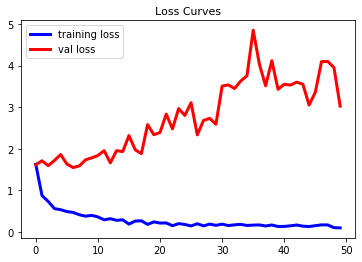

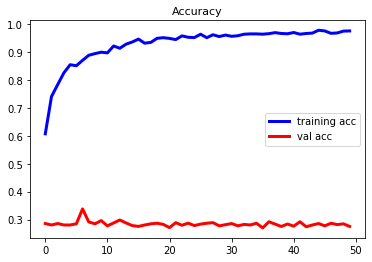

Training acc: 0.9748
val acc: 0.2754


In [197]:
#Plot the Loss Curves and accuracy

plt.plot(history.history['loss'],'b',linewidth=3.0, label='training loss')
plt.plot(history.history['val_loss'],'r',linewidth=3.0, label='val loss')
plt.title('Loss Curves',fontsize=11)
plt.legend()

plt.figure()
plt.plot(history.history['acc'],'b',linewidth=3.0, label='training acc')
plt.plot(history.history['val_acc'],'r',linewidth=3.0, label='val acc')
plt.title('Accuracy',fontsize=11)
plt.legend()
plt.show()

print("Training acc: {:.4f}".format(history.history['acc'][-1]))
print("val acc: {:.4f}".format(history.history['val_acc'][-1]))